In [1]:
import os
import pandas as pd
import numpy as np
import statistics
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 100

# Import 2008-2019 Economic Freedom Index (EFI) factor summary 2008-2019 and create DataFrame
ten_year_source = os.path.join('EF_Data_Sets', '2008-2019_combined.xls')
ten_year_df = pd.read_excel(ten_year_source)

# Import 2010 Economic Freedom Index data
data_2010 = os.path.join('EF_Data_Sets', 'index2010_data.xls')
df_2010 = pd.read_excel(data_2010)

# Import 2019 Economic Freedom Index data
current_year_source = os.path.join('EF_Data_Sets', 'index2019_data.xls')
df_2019 = pd.read_excel(current_year_source)

# DataFrame from the 2019 'name' and 'region' columns. Regions are not contained in the imported 2008-2019 summary.
region_col = [1, 3]
region_df = pd.read_excel(current_year_source, usecols = region_col)
region_df.rename(columns = {'Country Name': 'name', 'Region': 'region'}, inplace = True)

# Merge 2008-2019 summary and EFI region assignments on 'name'; allows us to get the 'region' column.
primary_df = pd.merge(ten_year_df, region_df,  how = 'outer', on = 'name')

# Filter 2019 from primary_df AS A COPY; safeguard from modifying primary_df when manipulating data in CIA merge/cleaning.
copy_2019_df = primary_df[primary_df['index year'] == 2019].copy(deep = True)

# Open 2019 CIA factbook with country profiles (data not contained in EFI or factor sub-scores).
mmxix = os.path.join('CIA_Info', '2019_CIA_factbook.json')
with open(mmxix, encoding = 'utf8') as jsonfile:
    cia_facts = json.load(jsonfile)

In [2]:
# DataFrame Tests

# ten_year_df.head()
# region_df.head()
# primary_df.head()
# copy_2019_df.head()
# df_2010.head()
# df_2019.head()

In [3]:
# DATA CLEANING: CIA DATA

# Work through country names to create search keys for .json file.

# Assign series of country names for data cleaning.
country_names = copy_2019_df['name']

# Drop hanging space from last character of name string.
end_space_dropped = []

for name in country_names:
    if name[-1] == ' ':
        end_clean = name[:-1]
        end_space_dropped.append(end_clean)        
    else:
        end_space_dropped.append(name)             
        
# Fill spaces and replace hyphens with '_' and misc data cleaning.
search_country = []

for name in end_space_dropped:
    spacefill = name.replace(' ', '_')
    formatted = spacefill.replace('-', '_')
    if formatted[:4] == 'The_':
        cleaned = formatted[4:] + '_The'
        search_country.append(cleaned)
    elif 'Congo' in formatted:
        if 'Democratic' in formatted:
            cleaned = 'Congo_Democratic_Republic_of_The'
            search_country.append(cleaned)
        else:
            cleaned = 'Congo_Republic_of_The'
            search_country.append(cleaned)                  
    elif 'Korea' in formatted:
        if 'South' in formatted:
            cleaned = 'Korea_South'
            search_country.append(cleaned)
        else:
            cleaned = 'Korea_North'
            search_country.append(cleaned)
    elif 'CÃ´' in formatted:
        cleaned = "Cote_d'_Ivoire"
        search_country.append(cleaned)
    elif 'Kyrgyz' in formatted:
        cleaned = 'Kyrgyzstan'
        search_country.append(cleaned)
    elif 'SÃ£o' in formatted:
        cleaned = 'Sao_Tome_and_Principe'
        search_country.append(cleaned)
    elif 'Brunei' in formatted:
        cleaned = name[:6]
        search_country.append(cleaned)
    elif 'Czech' in formatted:
        cleaned = name + 'ia'
        search_country.append(cleaned)
    elif 'Macedonia' in formatted:
        cleaned = 'North_' + name
        search_country.append(cleaned)
    elif 'Micronesia' in formatted:
        cleaned = name + '_Federated_States_of'
        search_country.append(cleaned)
    else:
        search_country.append(formatted)     

# Append the clean data to the 2019 dataframe.
copy_2019_df['search key'] = search_country

In [4]:
# GENERATE LISTS FOR CREATING A COMBINED DATAFRAME

# Empty lists for data collection.
name = []
pop = []
gvt = []
gdpv = []
gdpy = []
gdpr = []
gdppc = []
gdppcMATH = []
gdppy = []
gdppr = []

# List generation loop.
for country in search_country: 
    try:
# Master .json access path.
        access_country = cia_facts['countries'][country.lower()]
# CIA country name.
        name.append(country)
# Population.
        population = access_country['data']['people']['population']['total']
        pop.append(population)
# Form of government. (Ultimately did not use, required in-depth additional cleaning with too little time.)
        form_of_government = access_country['data']['government']['government_type']
        gvt.append(form_of_government)                                          
# GDP; report as (B. USD).
        gdp_value = (int(access_country
                        ['data']['economy']['gdp']['purchasing_power_parity']['annual_values'][0]['value'])/
                            1000000000)
        gdpv.append(gdp_value)
# GDP Year; to validate consistency in reported data.
        gdp_year = (access_country['data']['economy']['gdp']['purchasing_power_parity']['annual_values'][0]['date'])
        gdpy.append(gdp_year)      
# GDP Rank.
        gdp_rank = access_country['data']['economy']['gdp']['purchasing_power_parity']['global_rank']    
        gdpr.append(gdp_rank)
# Per Capita GDP; these are reported as quite rounded values.
        gdp_per_cap_round = (int(access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']
                                               ['annual_values'][0]['value']))
        gdppc.append(gdp_per_cap_round)
# Calculate actual Per Capita GDP.
        gdp_per_cap_MATH = (gdp_value*1000000000)/population
        gdppcMATH.append(gdp_per_cap_MATH)        
# Per Capita GDP Year.
        gdp_per_cap_year = (access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']
                                          ['annual_values'][0]['date'])
        gdppy.append(gdp_per_cap_year)
# Per Capita GDP Rank.
        gdp_per_cap_rank = access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']['global_rank']    
        gdppr.append(gdp_per_cap_rank)
        
    except KeyError:
# There is 1 KeyError. I could have written this into an if/else in this loop and eliminated the try/except...
        percapgdp = (gdp_value*1000000000)/population
        gdppc.append(percapgdp)
        gdppcMATH.append(percapgdp)        
        gdppy.append(gdp_year)
# Set rank '200'. There are 186 countries in EF set, more in CIA rankings. 200 falls in plot and doesn't distort image.
        gdppr.append('200')

In [5]:
# Create combined EFI and CIA dataframe for 2019.
cia_df = (pd.DataFrame(list(zip(name, pop, gvt, gdpv, gdpy, gdpr, gdppc, gdppy, gdppcMATH, gdppr)), 
          columns = ['search key', 'population', 'form of government', 'gdp (bil. usd)', 'gdp year', 'gdp rank', 
                     'per capita gdp (usd)', 'per capita gdp year', 'calculated per capita gdp (usd)', 'per capita rank']))

current_year_all_data_df = copy_2019_df.merge(cia_df, how = 'outer', on = 'search key').drop(columns = ['search key'])
current_year_all_data_df.head()

,name,index year,overall score,property rights,government integrity,judicial effectiveness,tax burden,government spending,fiscal health,business freedom,...,region,population,form of government,gdp (bil. usd),gdp year,gdp rank,per capita gdp (usd),per capita gdp year,calculated per capita gdp (usd),per capita rank
0,Afghanistan,2019.0,51.5,19.6,25.2,29.6,91.7,80.3,99.3,49.2,...,Asia-Pacific,34940837.0,presidential Islamic republic,69.45,2017,101.0,2000.0,2017,1987.645574,209
1,Albania,2019.0,66.5,54.8,40.4,30.6,86.3,73.9,80.6,69.3,...,Europe,3057220.0,parliamentary republic,36.01,2017,125.0,12500.0,2017,11778.674744,125
2,Algeria,2019.0,46.2,31.6,28.9,36.2,76.4,48.7,18.7,61.6,...,Middle East and North Africa,41657488.0,presidential republic,630.00,2017,36.0,15200.0,2017,15123.331488,109
3,Angola,2019.0,50.6,35.9,20.5,26.6,83.9,80.7,58.2,55.7,...,Sub-Saharan Africa,30355880.0,presidential republic,193.60,2017,65.0,6800.0,2017,6377.677076,160
4,Argentina,2019.0,52.2,47.8,33.5,44.5,69.3,49.5,33.0,56.4,...,Americas,44694198.0,presidential republic,922.10,2017,28.0,20900.0,2017,20631.313264,88


In [6]:
## TOP 5 EFI COUNTRIES 2019 for plotting 'cores' for identification onto the scatterplots.
china_df = current_year_all_data_df[current_year_all_data_df['name'] == 'China']
us_df = current_year_all_data_df[current_year_all_data_df['name'] == 'United States']
india_df = current_year_all_data_df[current_year_all_data_df['name'] == 'India']
japan_df = current_year_all_data_df[current_year_all_data_df['name'] == 'Japan']
germany_df = current_year_all_data_df[current_year_all_data_df['name'] == 'Germany']

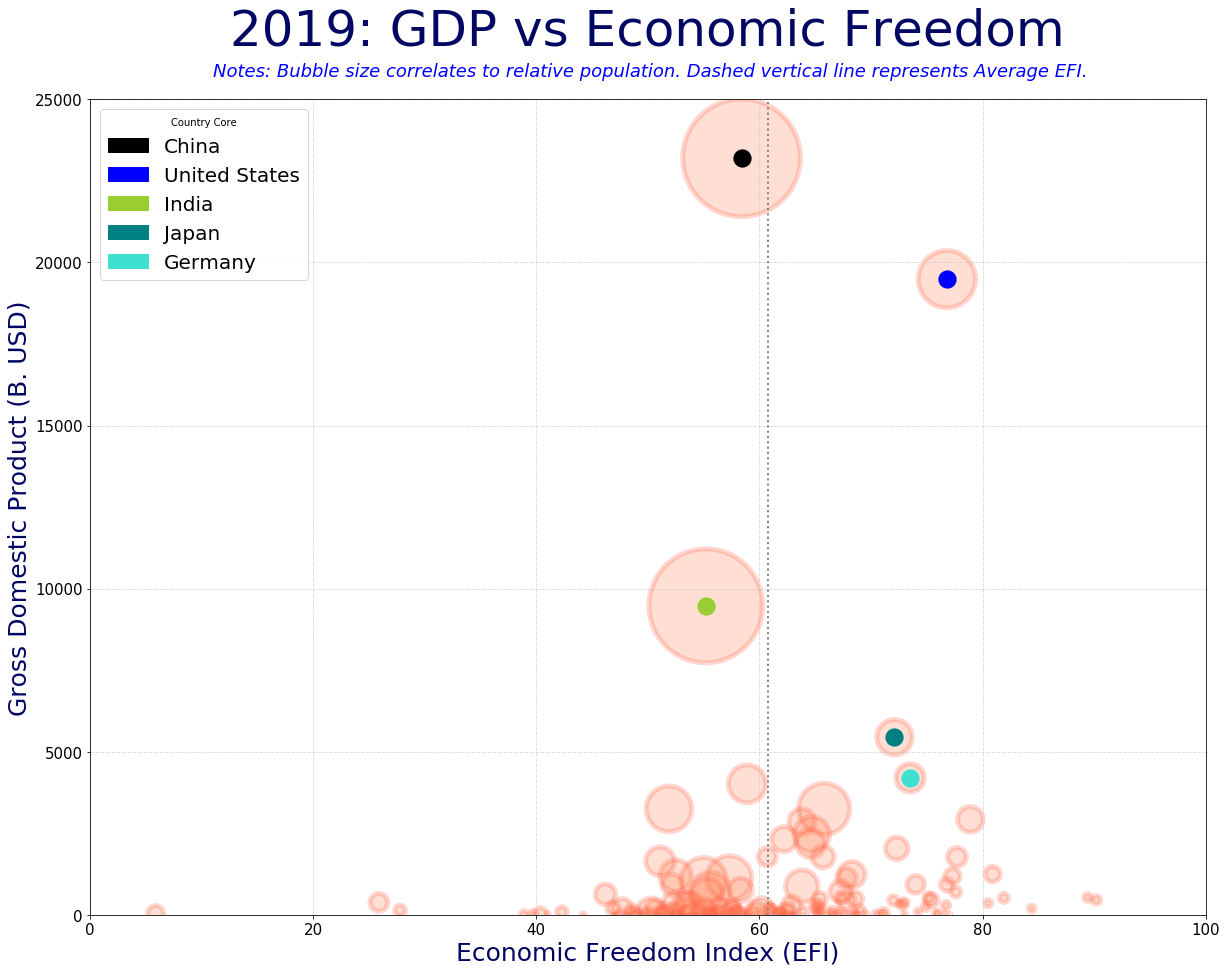

In [7]:
# SCATTER: GDP v EFI

# Set image size.
plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: GDP vs Economic Freedom', fontsize = 50, color = 'xkcd:darkblue', pad = 55)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25, color = 'xkcd:darkblue')
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Gross Domestic Product (B. USD)', fontsize = 25, color = 'xkcd:darkblue')
plt.ylim (0, 25000)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 

# PLOT SCATTER DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

# PLOT 'CORES'
plt.scatter(china_df['overall score'], china_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'black', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(us_df['overall score'], us_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(india_df['overall score'], india_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'yellowgreen', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(japan_df['overall score'], japan_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'teal', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(germany_df['overall score'], germany_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'turquoise', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, 25700, bubble_size, fontsize = 18, color = 'blue', style = 'italic', wrap = True)

# Add legend.
china_patch = mpatches.Patch(color = 'black', label = 'China')
us_patch = mpatches.Patch(color = 'blue', label = 'United States')
india_patch = mpatches.Patch(color = 'yellowgreen', label = 'India')
japan_patch = mpatches.Patch(color = 'teal', label = 'Japan')
germany_patch = mpatches.Patch(color = 'turquoise', label = 'Germany')

(plt.legend(title='Country Core', 
            handles = [china_patch, us_patch, india_patch, japan_patch, germany_patch], 
            fontsize = 20, 
            loc = 'upper left'))

# Save and show.
plt.savefig('Images/FIG_01_GDP_v_EFI.png')
plt.show()

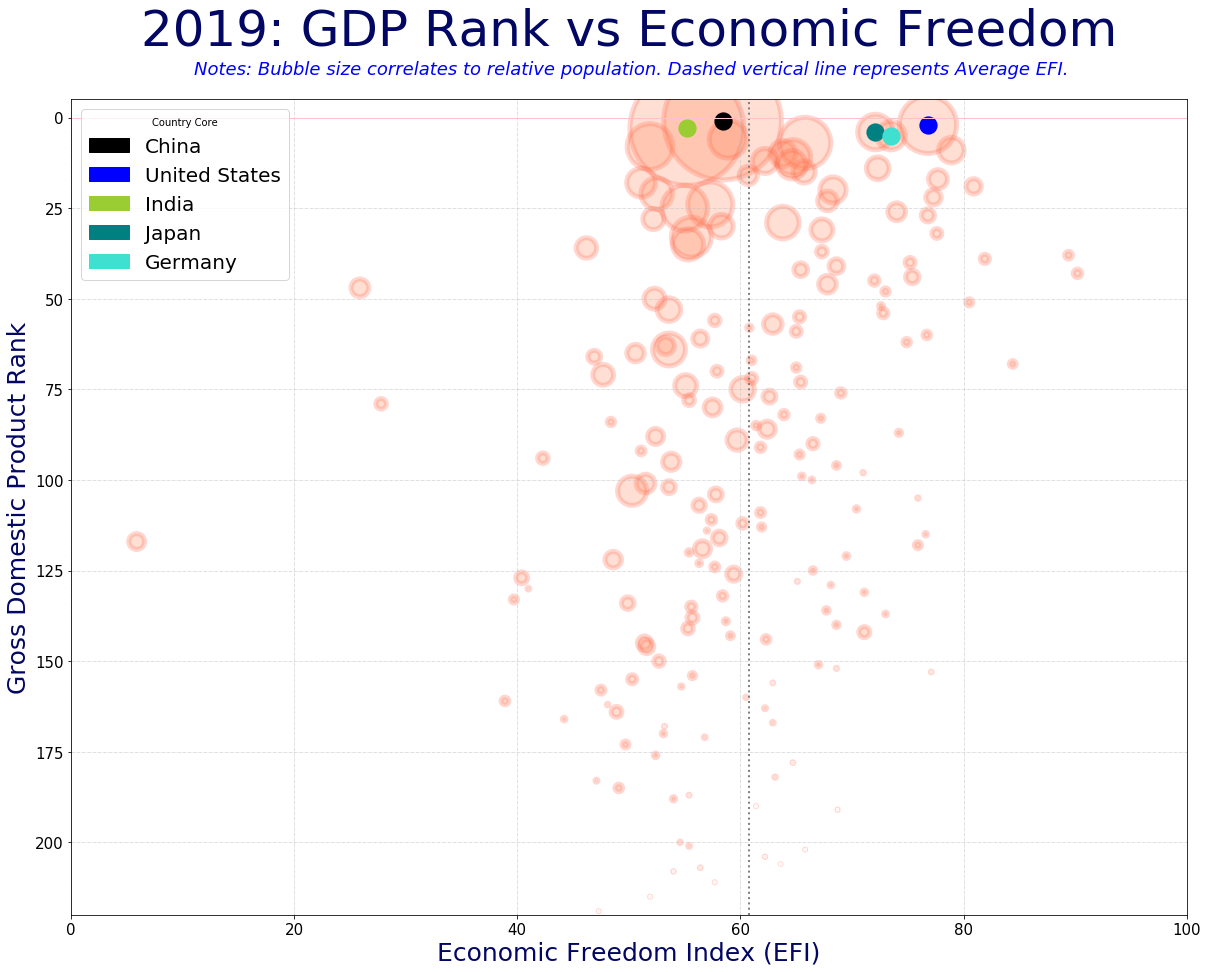

In [8]:
# SCATTER: GDP RANK v EFI

# Set image size.
plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: GDP Rank vs Economic Freedom', fontsize = 50, color = 'xkcd:darkblue', pad = 55)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25, color = 'xkcd:darkblue')
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Gross Domestic Product Rank', fontsize = 25, color = 'xkcd:darkblue')
plt.ylim (220, -5)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 
plt.axhline(0, lw = 1, c = 'pink') 


# PLOT SCATTER DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['gdp rank'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

# PLOT 'CORES'
plt.scatter(china_df['overall score'], china_df['gdp rank'], 
            marker = 'o', 
            c = 'black', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(us_df['overall score'], us_df['gdp rank'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(india_df['overall score'], india_df['gdp rank'], 
            marker = 'o', 
            c = 'yellowgreen', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(japan_df['overall score'], japan_df['gdp rank'], 
            marker = 'o', 
            c = 'teal', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(germany_df['overall score'], germany_df['gdp rank'], 
            marker = 'o', 
            c = 'turquoise', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, -12, bubble_size, fontsize = 18, color = 'blue', style = 'italic', wrap = True)

# Add legend.
us_patch = mpatches.Patch(color = 'blue', label = 'United States')
china_patch = mpatches.Patch(color = 'black', label = 'China')
india_patch = mpatches.Patch(color = 'yellowgreen', label = 'India')
japan_patch = mpatches.Patch(color = 'teal', label = 'Japan')
germany_patch = mpatches.Patch(color = 'turquoise', label = 'Germany')

(plt.legend(title = 'Country Core', 
            handles = [china_patch, us_patch, india_patch, japan_patch, germany_patch], 
            fontsize = 20, 
            loc = 'upper left'))

# Save and show.
plt.savefig('Images/FIG_02_GDP_Rank_v_EFI.png')
plt.show()

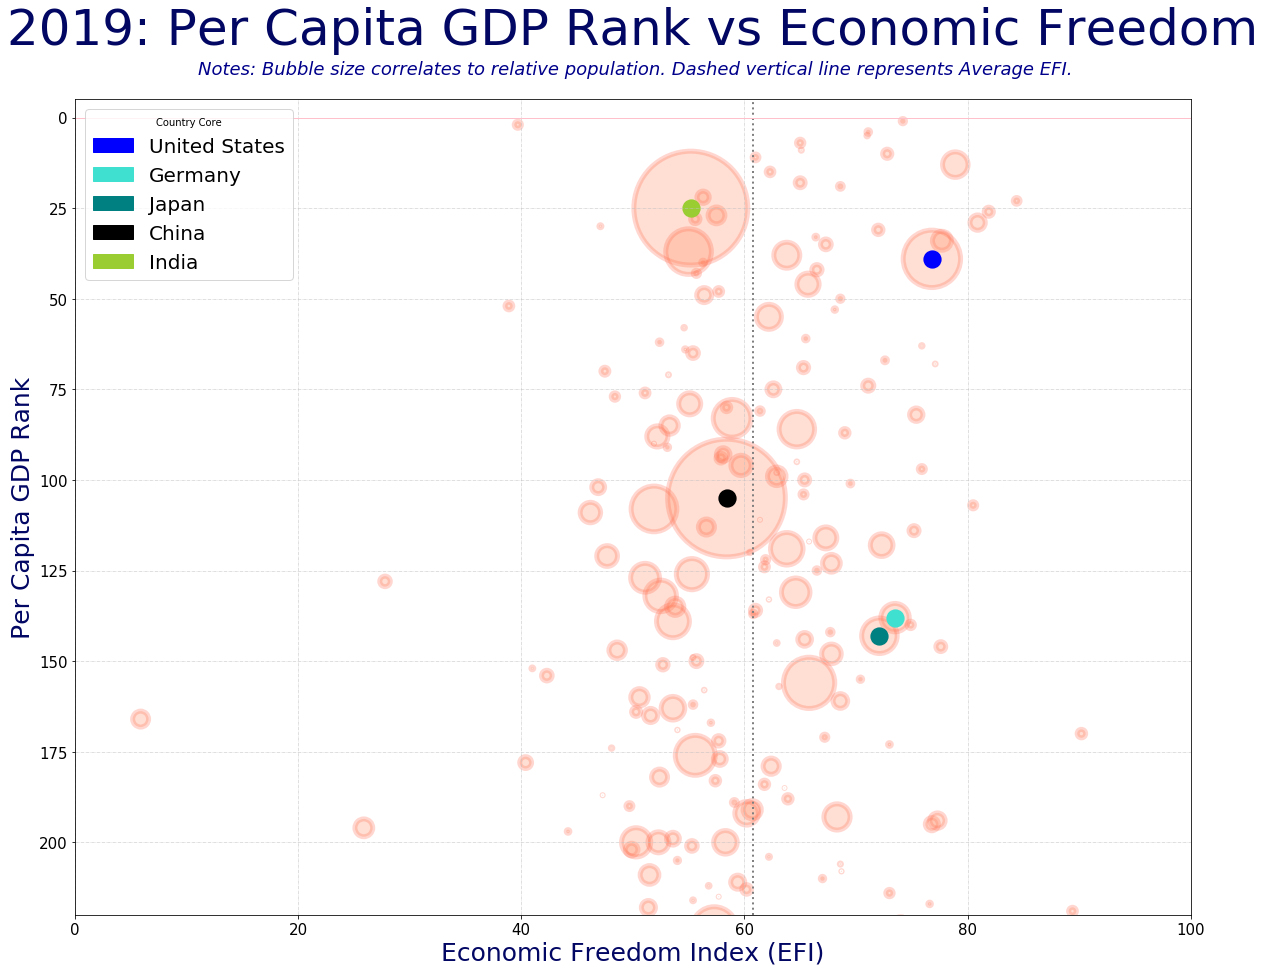

In [9]:
# SCATTER: GDP PER CAPITA RANK v EFI

# Set image size.
plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: Per Capita GDP Rank vs Economic Freedom', fontsize = 50, color = 'xkcd:darkblue', pad = 55)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25, color = 'xkcd:darkblue')
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Per Capita GDP Rank', fontsize = 25, color = 'xkcd:darkblue')
plt.ylim (220, -5)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 
plt.axhline(0, lw = 1, c = 'pink') 


# PLOT SCATTER DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['per capita rank'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

# PLOT 'CORES'
plt.scatter(china_df['overall score'], china_df['per capita rank'], 
            marker = 'o', 
            c = 'black', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(us_df['overall score'], us_df['per capita rank'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(india_df['overall score'], india_df['per capita rank'], 
            marker = 'o', 
            c = 'yellowgreen', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(japan_df['overall score'], japan_df['per capita rank'], 
            marker = 'o', 
            c = 'teal', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)
plt.scatter(germany_df['overall score'], germany_df['per capita rank'], 
            marker = 'o', 
            c = 'turquoise', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, -12, bubble_size, fontsize = 18, color = 'darkblue', style = 'italic', wrap = True)

# Add legend.
us_patch = mpatches.Patch(color = 'blue', label = 'United States')
china_patch = mpatches.Patch(color = 'black', label = 'China')
india_patch = mpatches.Patch(color = 'yellowgreen', label = 'India')
japan_patch = mpatches.Patch(color = 'teal', label = 'Japan')
germany_patch = mpatches.Patch(color = 'turquoise', label = 'Germany')

(plt.legend(title = 'Country Core', 
            handles = [us_patch, germany_patch, japan_patch, china_patch, india_patch], 
            fontsize = 20, 
            loc = 'upper left'))

# Save and show.
plt.savefig('Images/FIG_03_PerCapGDP_Rank_v_EFI.png')
plt.show()

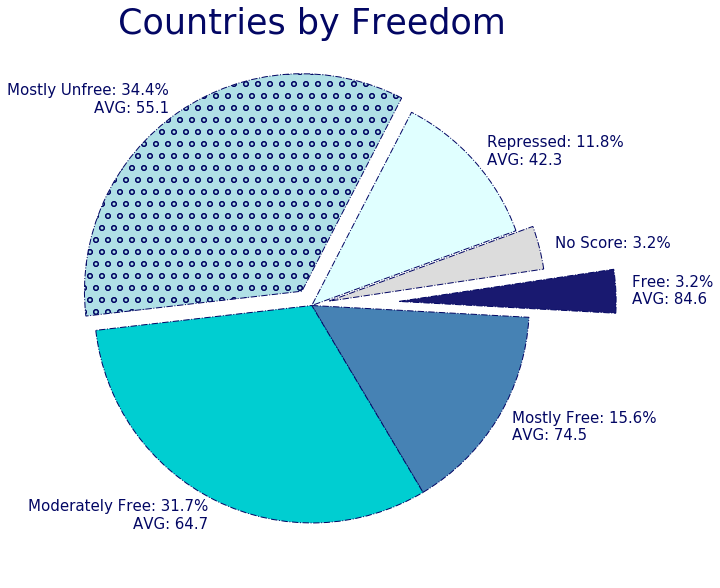

In [10]:
# PIE: PERCENTAGE OF COUNTRIES BY FREEDOM CLASSIFICATION

# Create lists for freedom classifications.
free = []
mfree = []
moderate = []
munfree = []
repressed = []
unscored = []

score_free = []
score_mfree = []
score_moderate = []
score_munfree = []
score_repressed = []

reference = list(zip(current_year_all_data_df['name'], current_year_all_data_df['overall score']))

for item in reference:
    if item[1] >= 80:
        free.append(item[0])
        score_free.append(item[1])
    elif item[1] >= 70 and item[1] < 80:
        mfree.append(item[0])
        score_mfree.append(item[1])    
    elif item[1] >= 60 and item[1] < 70:
        moderate.append(item[0])
        score_moderate.append(item[1])        
    elif item[1] >= 50 and item[1] < 60:
        munfree.append(item[0])
        score_munfree.append(item[1])    
    elif item[1] >= 1 and item[1] < 50:
        repressed.append(item[0])
        score_repressed.append(item[1])        
    else:
        unscored.append(item[0])
        
# Denise wrote better code for this via binning (included further below), but this is what was written and 'presented'.
# I couldn't remember the binning process at the time but this worked!

# Total countries for label math.
country_count = len(reference)

# Reference list of country counts by classification for label math.
classifications = [len(free), len(mfree), len(moderate), len(munfree), len(repressed), len(unscored)]

# Set labels with representative percentages.
# I prefer the LOOK of this vs the standard label with pct within slice look (narrow slices)...
# I couldn't figure how to wrap this for ease of reading without 'SyntaxError: EOL while scanning string literal', sorry!
freedom_labels = ([(f'Free: {round(classifications[0]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_free), 1)}'), 
                   (f'Mostly Free: {round(classifications[1]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_mfree), 1)}'), 
                   (f'Moderately Free: {round(classifications[2]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_moderate), 1)}'), 
                   (f'Mostly Unfree: {round(classifications[3]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_munfree), 1)}'), 
                   (f'Repressed: {round(classifications[4]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_repressed), 1)}'), 
                   (f'No Score: {round(classifications[5]/country_count*100, 1)}%')])

# Set slice colors. [This was fun but took much Google-Fu]
freedom_colors = (['#191970',  # Midnight Blue
                   '#4682B4',  # Steel Blue
                   '#00CED1',  # Dark Turquoise
                   '#B0E0E6',  # Powder Blue
                   '#E0FFFF',  # Light Cyan
                   '#DCDCDC']) # Gainsboro

# Set image size.
fig, ax = plt.subplots(figsize = (12, 10))

# Label with size/color options. Set aspect.
ax.set_title('Countries by Freedom', fontsize = 35, pad = 0, color = 'xkcd:darkblue')
ax.set(aspect = 'equal')

# Get to the PLOT already!
patches = plt.pie(classifications, 
        labels = freedom_labels, 
        labeldistance = 1.075, 
        textprops = {'fontsize': 15, 'color': 'xkcd:darkblue'}, 
        wedgeprops = {'edgecolor': 'xkcd:darkblue', 'linewidth': 1, 'linestyle': '-.', 'hatch': '', 'antialiased': True}, 
        colors = freedom_colors, 
        counterclock = False, 
        startangle = 8.5, 
        explode = (.4, .0, .0, .08, .0, 0.08), 
        shadow = False)[0]

# Add some interest to the plot. Choosing slice of greatest percentage for emphasis.
patches[3].set_hatch('o')

# Save and show.
plt.savefig('Images/FIG_04_Countries_by_Freedom.png')
plt.show()

In [11]:
# Sorted the DataFrame first by "index year" and second by "name".
index_year_df = primary_df.sort_values(by=["index year", "name"], ascending=True)
index_year_df.head()

,name,index year,overall score,property rights,government integrity,judicial effectiveness,tax burden,government spending,fiscal health,business freedom,labor freedom,monetary freedom,trade freedom,investment freedom,financial freedom,region
11,Afghanistan,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia-Pacific
23,Albania,2008.0,62.4,30.0,26.0,NaN,90.3,76.0,NaN,55.6,49.5,80.4,75.8,70.0,70.0,Europe
35,Algeria,2008.0,56.2,30.0,31.0,NaN,77.0,74.6,NaN,73.6,57.0,80.2,68.8,40.0,30.0,Middle East and North Africa
47,Angola,2008.0,46.9,20.0,22.0,NaN,85.2,72.8,NaN,36.7,41.5,57.8,73.0,20.0,40.0,Sub-Saharan Africa
59,Argentina,2008.0,54.2,30.0,29.0,NaN,70.5,80.9,NaN,63.7,42.9,65.0,69.6,50.0,40.0,Americas


In [12]:
# Find average overall world score for 2009
scores_2010 = index_year_df[index_year_df["index year"] == 2010.0]
average_2010 = scores_2010["overall score"].mean()
average_2010

59.365363128491595

In [13]:
# Find average overall world score for 2019
scores_2019 = index_year_df[index_year_df["index year"] == 2019.0]
average_2019 = scores_2019["overall score"].mean()
average_2019

60.76833333333333

In [14]:
# Find average score for the 10 factors for 2010
property_rights_2010 = scores_2010["property rights"].mean()
property_2010 = round(property_rights_2010, 1)

govt_integrity_2010 = scores_2010["government integrity"].mean()
govt_2010 = round(govt_integrity_2010, 1)

tax_burden_2010 = scores_2010["tax burden"].mean()
tax_2010 = round(tax_burden_2010, 1)

govt_spend_2010 = scores_2010["government spending"].mean()
spend_2010 = round(govt_spend_2010, 1)

business_freedom_2010 = scores_2010["business freedom"].mean()
business_2010 = round(business_freedom_2010, 1)

labor_freedom_2010 = scores_2010["labor freedom"].mean()
labor_2010 = round(labor_freedom_2010, 1)

monetary_freedom_2010 = scores_2010["monetary freedom"].mean()
monetary_2010 = round(monetary_freedom_2010, 1)

trade_freedom_2010 = scores_2010["trade freedom"].mean()
trade_2010 = round(trade_freedom_2010, 1)

invest_freedom_2010 = scores_2010["investment freedom"].mean()
invest_2010 = round(invest_freedom_2010, 1)

financial_freedom_2010 = scores_2010["financial freedom"].mean()
financial_2010 = round(financial_freedom_2010, 1)

In [15]:
# Combine the average scores into a list to easily plot the values
averages_2010 = [property_2010, govt_2010, tax_2010, spend_2010, business_2010, labor_2010, monetary_2010,
                 trade_2010, invest_2010, financial_2010]
averages_2010

[43.8, 40.5, 75.4, 65.0, 64.6, 62.1, 70.6, 74.2, 49.0, 48.5]

In [16]:
# Find average score for the 10 factors for 2019
property_rights_2019 = scores_2019["property rights"].mean()
property_2019 = round(property_rights_2019, 1)

govt_integrity_2019 = scores_2019["government integrity"].mean()
govt_2019 = round(govt_integrity_2019, 1)

tax_burden_2019 = scores_2019["tax burden"].mean()
tax_2019 = round(tax_burden_2019, 1)

govt_spend_2019 = scores_2019["government spending"].mean()
spend_2019 = round(govt_spend_2019, 1)

business_freedom_2019 = scores_2019["business freedom"].mean()
business_2019 = round(business_freedom_2019, 1)

labor_freedom_2019 = scores_2019["labor freedom"].mean()
labor_2019 = round(labor_freedom_2019, 1)

monetary_freedom_2019 = scores_2019["monetary freedom"].mean()
monetary_2019 = round(monetary_freedom_2019, 1)

trade_freedom_2019 = scores_2019["trade freedom"].mean()
trade_2019 = round(trade_freedom_2019, 1)

invest_freedom_2019 = scores_2019["investment freedom"].mean()
invest_2019 = round(invest_freedom_2019, 1)

financial_freedom_2019 = scores_2019["financial freedom"].mean()
financial_2019 = round(financial_freedom_2019, 1)

In [17]:
# Combine the average scores into a list to easily plot the values
averages_2019 = [property_2019, govt_2019, tax_2019, spend_2019, business_2019, labor_2019, monetary_2019,
                 trade_2019, invest_2019, financial_2019]
averages_2019

[52.3, 41.5, 77.2, 64.2, 63.5, 59.4, 75.1, 74.3, 57.3, 48.8]

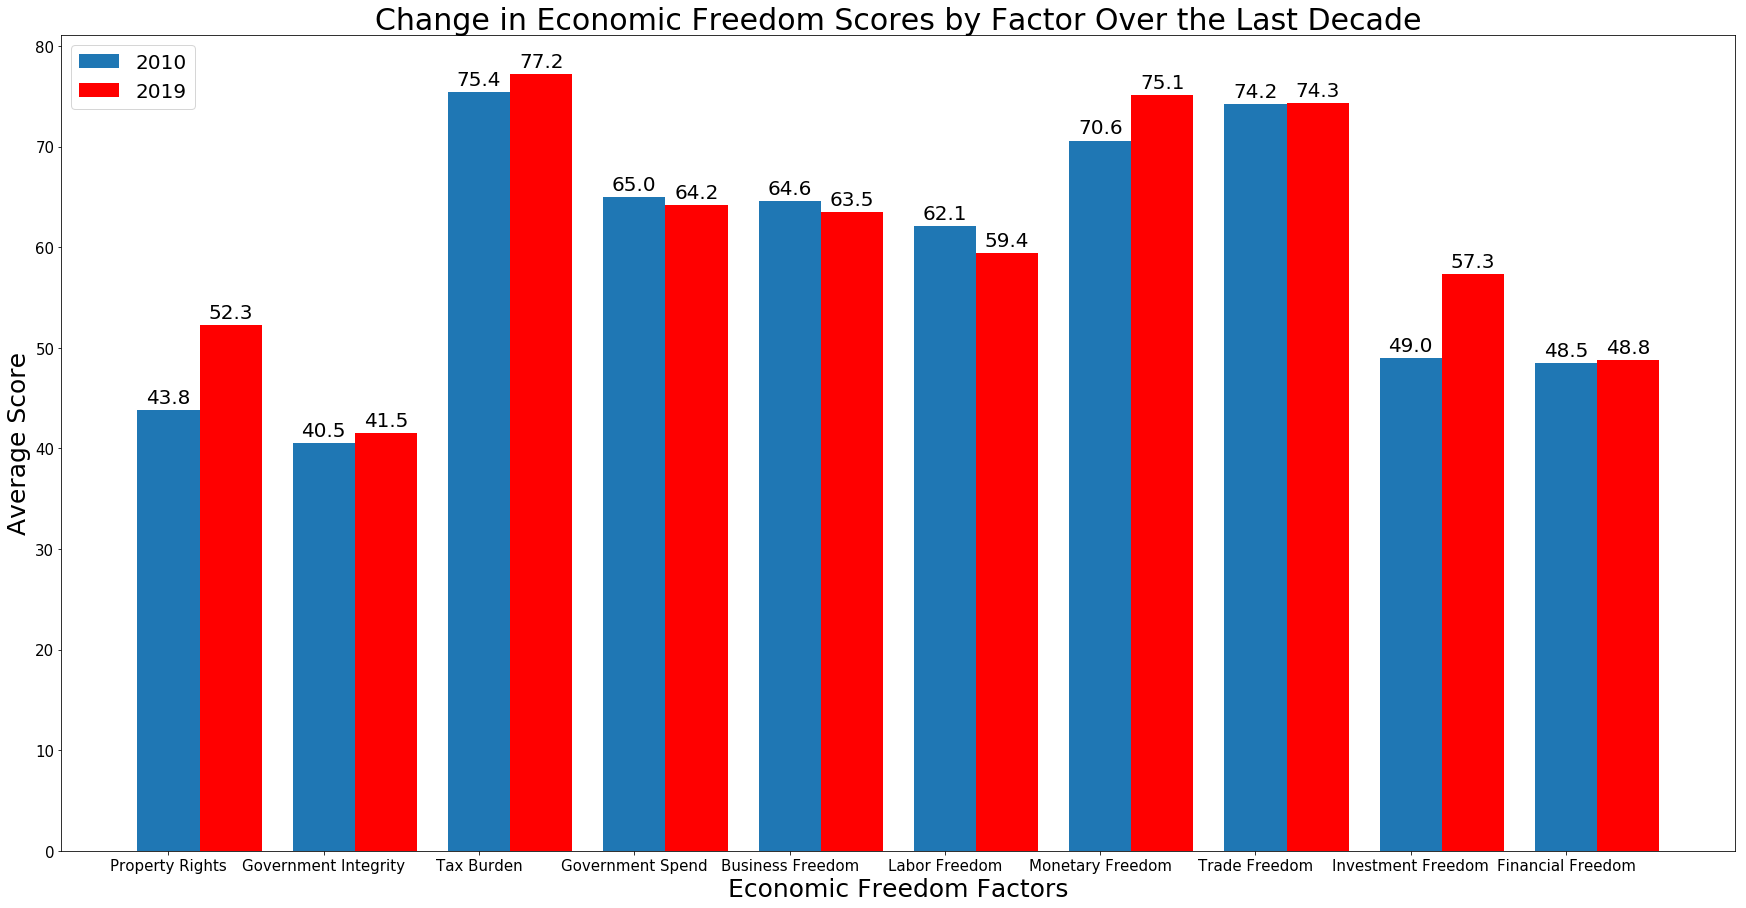

In [18]:
# Get 10 numbers to hold the place for the 10 economic factors and create a list to hold the legend labels
x = np.arange(10)
labels = ["2010", "2019"]

# Plot the multiple bar chart with 2010 and 2019 freedom factor values 
plt.figure(figsize=(30, 15))
scores_2010 = plt.bar(x, averages_2010, width=.4)
scores_2019 = plt.bar(x + .4, averages_2019, width=.4, color="r")

# Title the chart, label the axes, and adjust the fonts
plt.title("Change in Economic Freedom Scores by Factor Over the Last Decade", fontsize=30)
plt.ylabel("Average Score", fontsize=25)
plt.xlabel("Economic Freedom Factors", fontsize=25)

# Adjust the font size of the ticks and change the xticks from numeric to the appropriate freedom factors
plt.yticks(fontsize=15)
plt.xticks(np.arange(10), ("Property Rights", "Government Integrity", "Tax Burden", "Government Spend", 
                         "Business Freedom", "Labor Freedom", "Monetary Freedom", "Trade Freedom", 
                         "Investment Freedom", "Financial Freedom"), fontsize=15)

# Place the legend in the upper left
plt.legend(labels, loc="upper left", fontsize=20)

# Defined a function to calculate the heights of each bar and display the numeric height at the top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/ 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)
autolabel(scores_2010)
autolabel(scores_2019)

# Save the figure
plt.savefig("Images/FIG_05_decade_change_factors_scores.png")

In [19]:
# Import the 2010 and 2019 combined dataset
data_2010_2019 = os.path.join('EF_Data_Sets', '2010_2019_overall_scores.xls')

df_2010_2019 = pd.read_excel(data_2010_2019)

# Set the index to the "name" of the countries
df_2010_2019 = df_2010_2019.set_index(["name"])
df_2010_2019.head()

,index year,overall score,2010 score
name,,,
Afghanistan,2019,51.5,NaN
Albania,2019,66.5,66.0
Algeria,2019,46.2,56.9
Angola,2019,50.6,48.4
Argentina,2019,52.2,51.2


In [20]:
# Calculate the percentage change in score for each country from 2010 to 2019
percents = (df_2010_2019["overall score"] - df_2010_2019["2010 score"]) / df_2010_2019["2010 score"] * 100
percents.head()

name
Afghanistan          NaN
Albania         0.757576
Algeria       -18.804921
Angola          4.545455
Argentina       1.953125
dtype: float64

In [21]:
# Sort the DataFrame by ascending values to see the 10 countries with the largest decrease in overall score
percent_changes = pd.DataFrame(percents)
percent_changes = percent_changes.rename(columns={0: "percent_changes"})
percent_changes = percent_changes.round(1)
sorted_percents = percent_changes.sort_values(["percent_changes"], ascending=True).head(10)

# Creat a new DataFrame that only includes the 10 countries with the largest percentage declines in score
# Format the cells so they are rounded and have % signs
sorted_percents = sorted_percents["percent_changes"][:10]
bottom10_changes = pd.DataFrame(sorted_percents)
bottom10_change = bottom10_changes.style.format({"percent_changes": "{:,.1f}%".format})

bottom10_change

,percent_changes
name,
Venezuela,-30.2%
Algeria,-18.8%
Equatorial Guinea,-15.6%
Bolivia,-14.4%
Lebanon,-14.1%
Mozambique,-13.2%
Trinidad and Tobago,-13.2%
Bahrain,-13.0%
El Salvador,-11.6%


In [22]:
# Drop the rows containing data for the years 2008 and 2009
index_year_df = index_year_df.rename(columns={"index year": "index_year", "overall score": "overall_score"})
index_year_df = index_year_df[index_year_df.index_year != 2008.0]
index_year_df = index_year_df[index_year_df.index_year != 2009.0]

# Separate each of the bottom 10 countries into their own DataFrame
decade_df = index_year_df[["index_year", "name", "overall_score"]]
venezuela_df = decade_df[decade_df["name"] == "Venezuela "]
algeria_df = decade_df[decade_df["name"] == "Algeria"]
eguinea_df = decade_df[decade_df["name"] == "Equatorial Guinea"]
bolivia_df = decade_df[decade_df["name"] == "Bolivia"]
lebanon_df = decade_df[decade_df["name"] == "Lebanon"]
trinidad_df = decade_df[decade_df["name"] == "Trinidad and Tobago"]
mozambique_df = decade_df[decade_df["name"] == "Mozambique "]
bahrain_df = decade_df[decade_df["name"] == "Bahrain"]
salvador_df = decade_df[decade_df["name"] == "El Salvador "]
egypt_df = decade_df[decade_df["name"] == "Egypt"]

In [23]:
# Merge all 10 DataFrames into one
bottom10_df = pd.merge(venezuela_df, algeria_df, how="outer")
bottom10_df = pd.merge(bottom10_df, eguinea_df, how="outer")
bottom10_df = pd.merge(bottom10_df, bolivia_df, how="outer")
bottom10_df = pd.merge(bottom10_df, lebanon_df, how="outer")
bottom10_df = pd.merge(bottom10_df, trinidad_df, how="outer")
bottom10_df = pd.merge(bottom10_df, mozambique_df, how="outer")
bottom10_df = pd.merge(bottom10_df, bahrain_df, how="outer")
bottom10_df = pd.merge(bottom10_df, salvador_df, how="outer")
bottom10_df = pd.merge(bottom10_df, egypt_df, how="outer")

# Rename the columns so they have no spaces
bottom10_df = bottom10_df.rename(columns={"index year": "index_year", "overall score": "overall_score"})
bottom10_df.head()

,index_year,name,overall_score
0,2010.0,Venezuela,37.1
1,2011.0,Venezuela,37.6
2,2012.0,Venezuela,38.1
3,2013.0,Venezuela,36.1
4,2014.0,Venezuela,36.3


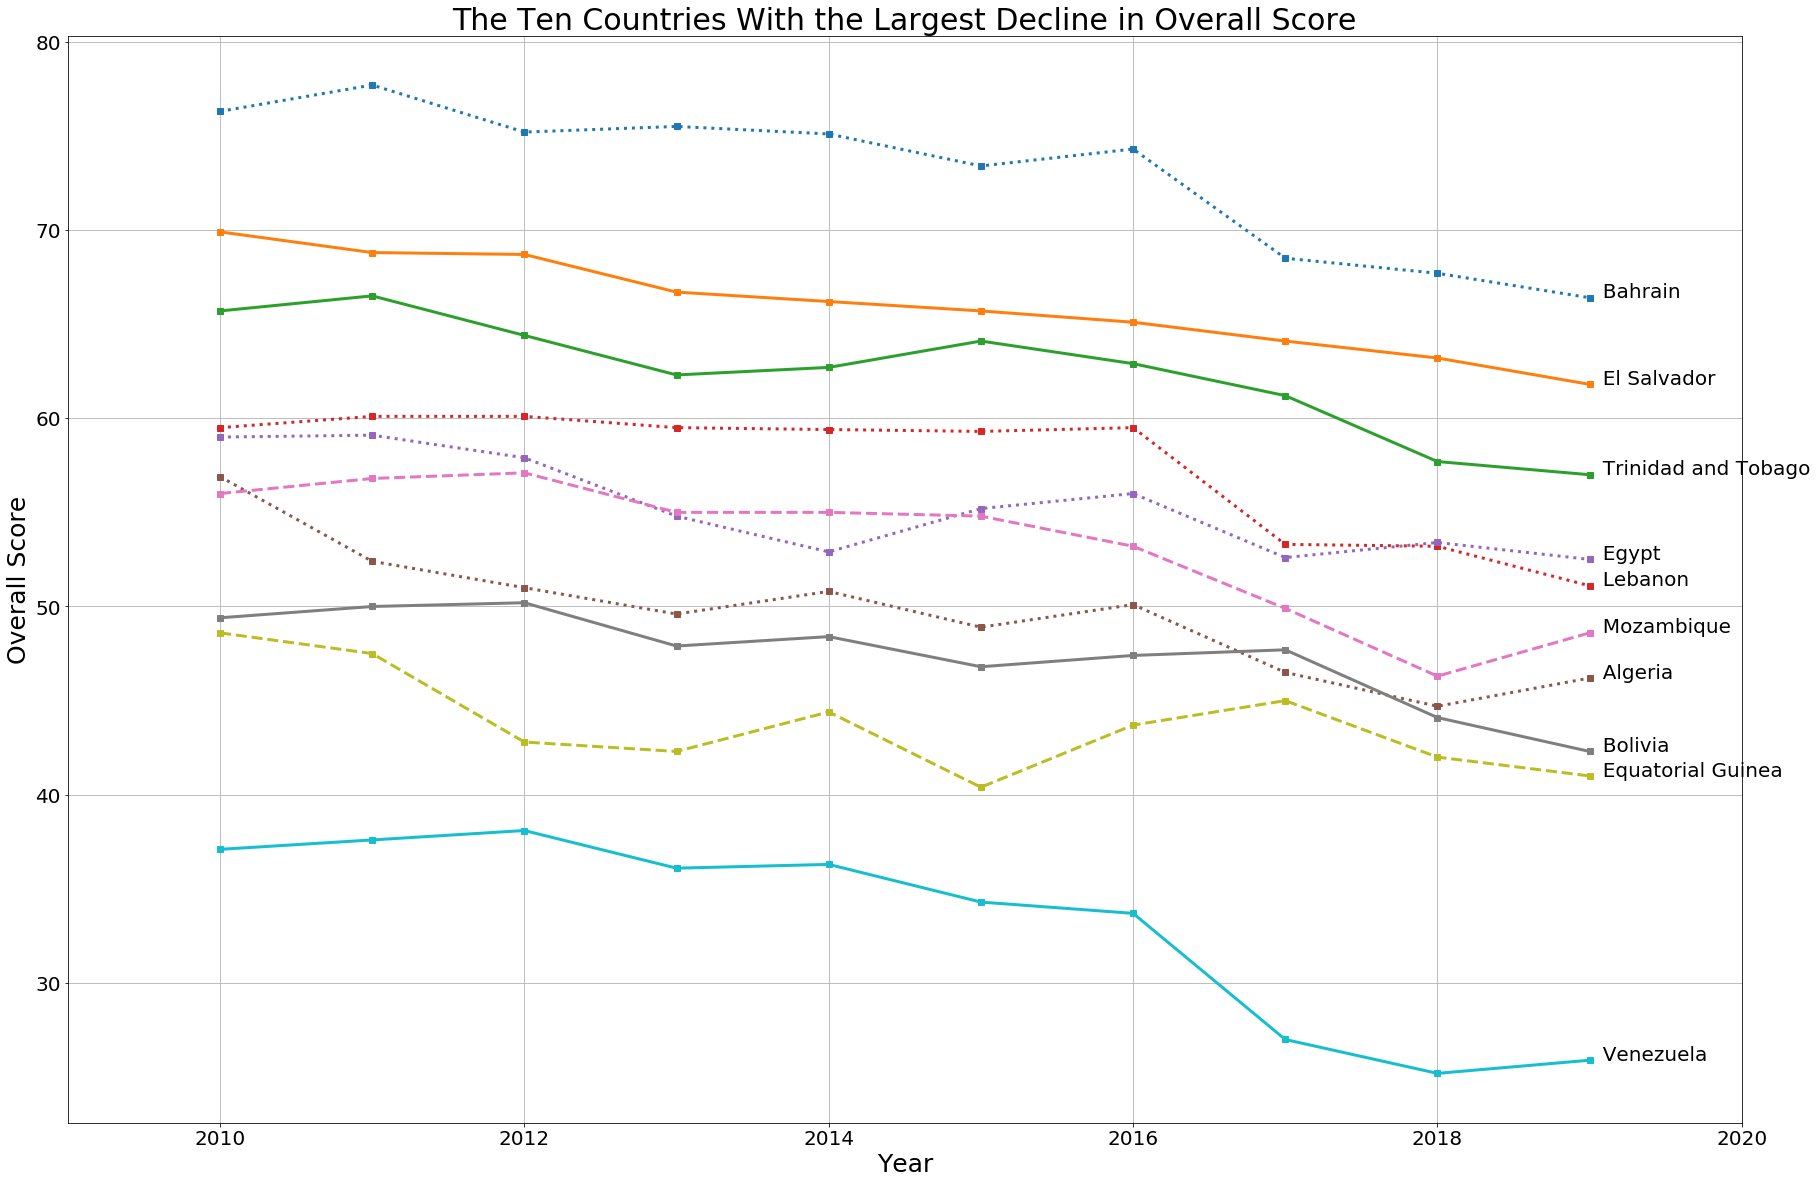

In [24]:
# Plot the 10 year data for each country on a separate line in the chart
# Solid linestyle is Americas region
# Dotted linestyle is North Africa/Middle East region
# Dashed linestyle is Sub-Saharan Africa region
plt.figure(figsize=(30,20))
plt.plot(bahrain_df["index_year"], bahrain_df["overall_score"], linewidth=3, marker="s", linestyle=":")
plt.plot(salvador_df["index_year"], salvador_df["overall_score"], linewidth=3, marker="s")
plt.plot(trinidad_df["index_year"], trinidad_df["overall_score"], linewidth=3, marker="s")
plt.plot(lebanon_df["index_year"], lebanon_df["overall_score"], linewidth=3, marker="s", linestyle=":")
plt.plot(egypt_df["index_year"], egypt_df["overall_score"], linewidth=3, marker="s", linestyle=":")
plt.plot(algeria_df["index_year"], algeria_df["overall_score"], linewidth=3, marker="s", linestyle=":")
plt.plot(mozambique_df["index_year"], mozambique_df["overall_score"], linewidth=3, marker="s", linestyle="--")
plt.plot(bolivia_df["index_year"], bolivia_df["overall_score"], linewidth=3, marker="s")
plt.plot(eguinea_df["index_year"], eguinea_df["overall_score"],linewidth=3, marker="s", linestyle="--")
plt.plot(venezuela_df["index_year"], venezuela_df["overall_score"], linewidth=3, marker="s")

# Place a black text label at the end of each plotted line rather than use a legend
plt.text(2019, bahrain_df.overall_score.tail(1), "  Bahrain", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, salvador_df.overall_score.tail(1), "  El Salvador", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, trinidad_df.overall_score.tail(1), "  Trinidad and Tobago", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, lebanon_df.overall_score.tail(1), "  Lebanon", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, egypt_df.overall_score.tail(1), "  Egypt", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, algeria_df.overall_score.tail(1), "  Algeria", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, mozambique_df.overall_score.tail(1), "  Mozambique", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, bolivia_df.overall_score.tail(1), "  Bolivia", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, eguinea_df.overall_score.tail(1), "  Equatorial Guinea", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, venezuela_df.overall_score.tail(1), "  Venezuela", horizontalalignment="left", fontsize=20, color="k")

# Title the chart, label the axes, add a legend, add gridlines, and adjust the font sizes
plt.title("The Ten Countries With the Largest Decline in Overall Score", fontsize=30)
plt.ylabel("Overall Score", fontsize=25)
plt.xlabel("Year", fontsize=25)
plt.xlim(2009, 2020)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid()

# Save the figure
plt.savefig("Images/FIG_06_bottom10_countries.png")


In [25]:
# Rename the columns and merge the DataFrames together
df_2010 = df_2010[['name', 'index year', 'overall score']]
df_2019 = df_2019.rename(columns={'Country Name':'name', '2019 Score':'overall score'})
df_2019 = df_2019[['name', 'overall score']]

df_2019['year'] = '2019'
merged_df = pd.merge(df_2010, df_2019, on='name', how='left')
merged_df.count()

name               183
index year         183
overall score_x    179
overall score_y    151
year               156
dtype: int64

In [26]:
#Drop all countries with NaN since we cannot compare their scores over the last decade
merged_df = merged_df.dropna(how="any")
merged_df.count()

name               149
index year         149
overall score_x    149
overall score_y    149
year               149
dtype: int64

In [27]:
# Display combined data for 2010 and 2019 overall scores
merged_df= merged_df.rename(columns={"index year": "year_2010", 
                                     "overall score_x":"score_2010", 
                                     "overall score_y": "score_2019",
                                     "year": "year_2019"})
merged_df.head()

,name,year_2010,score_2010,score_2019,year_2019
1,Albania,2010,66.0,66.5,2019
2,Algeria,2010,56.9,46.2,2019
3,Angola,2010,48.4,50.6,2019
4,Argentina,2010,51.2,52.2,2019
5,Armenia,2010,69.2,67.7,2019


In [28]:
#Reset the index
#merged_df = merged_df.reset_index(drop=True)
#merged_df = merged_df.set_index(["name"])
merged_df.head()

,name,year_2010,score_2010,score_2019,year_2019
1,Albania,2010,66.0,66.5,2019
2,Algeria,2010,56.9,46.2,2019
3,Angola,2010,48.4,50.6,2019
4,Argentina,2010,51.2,52.2,2019
5,Armenia,2010,69.2,67.7,2019


In [29]:
#Calculate the change in score for each country from 2010 to 2019
decade_change = ((merged_df["score_2019"]/merged_df["score_2010"])-1)*100
decade_change.head()

1     0.757576
2   -18.804921
3     4.545455
4     1.953125
5    -2.167630
dtype: float64

In [30]:
# Find the top 10 largest change in overall score between 2019-2010 and put into DataFrame
top_10 = decade_change.nlargest(10)
top_10_df = pd.DataFrame(top_10)
top_10_df = top_10_df.rename(columns={0: "percent_change"})
top_10_df = top_10_df.round(1)
top_10_df

# Create dataframe for the top 10 countries with largest percentage increase

top_10_change = top_10_df.style.format({"percent_change": "{:,.1f}%".format})
top_10_change

,percent_change
182,88.8%
23,46.0%
142,28.2%
147,27.3%
64,23.9%
34,23.4%
134,20.3%
12,18.9%
72,18.6%
73,17.7%


In [31]:
#Sort the DataFrame by index year and by name
index_year_df = primary_df.sort_values(by=["index year", "name"], ascending=True)
index_year_df.head()

,name,index year,overall score,property rights,government integrity,judicial effectiveness,tax burden,government spending,fiscal health,business freedom,labor freedom,monetary freedom,trade freedom,investment freedom,financial freedom,region
11,Afghanistan,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia-Pacific
23,Albania,2008.0,62.4,30.0,26.0,NaN,90.3,76.0,NaN,55.6,49.5,80.4,75.8,70.0,70.0,Europe
35,Algeria,2008.0,56.2,30.0,31.0,NaN,77.0,74.6,NaN,73.6,57.0,80.2,68.8,40.0,30.0,Middle East and North Africa
47,Angola,2008.0,46.9,20.0,22.0,NaN,85.2,72.8,NaN,36.7,41.5,57.8,73.0,20.0,40.0,Sub-Saharan Africa
59,Argentina,2008.0,54.2,30.0,29.0,NaN,70.5,80.9,NaN,63.7,42.9,65.0,69.6,50.0,40.0,Americas


In [32]:
#Drop the rows containing data for years  2008 and 2009
index_year_df = index_year_df.rename(columns={"index year": "index_year", "overall score":  "overall_score"})
index_year_df = index_year_df[index_year_df.index_year != 2008.0]
index_year_df = index_year_df[index_year_df.index_year != 2009.0]

# Separate each of the top 10 countries into their own DataFrame
decade_df = index_year_df[["index_year", "name", "overall_score"]]
zimbabwe_df = decade_df[decade_df["name"] == "Zimbabwe"]
burma_df = decade_df[decade_df["name"] == "Burma"]
seychelles_df = decade_df[decade_df["name"] == "Seychelles"]
solomon_df = decade_df[decade_df["name"] == "Solomon Islands"]
guinea_df = decade_df[decade_df["name"] == "Guinea-Bissau"]
comoros_df = decade_df[decade_df["name"] == "Comoros"]
rwanda_df = decade_df[decade_df["name"] == "Rwanda"]
belarus_df = decade_df[decade_df["name"] == "Belarus"]
indonesia_df = decade_df[decade_df["name"] == "Indonesia"]
iran_df = decade_df[decade_df["name"] == "Iran"]

In [33]:
# Merge all DataFrames into one
highest10_df = pd.merge(zimbabwe_df, burma_df, how= "outer")
highest10_df = pd.merge(highest10_df, seychelles_df, how= "outer")
highest10_df = pd.merge(highest10_df, solomon_df, how= "outer")
highest10_df = pd.merge(highest10_df, guinea_df, how= "outer")
highest10_df = pd.merge(highest10_df, comoros_df, how= "outer")
highest10_df = pd.merge(highest10_df, rwanda_df, how= "outer")
highest10_df = pd.merge(highest10_df, belarus_df, how= "outer")
highest10_df = pd.merge(highest10_df, indonesia_df, how= "outer")
highest10_df = pd.merge(highest10_df, iran_df, how= "outer")

#Rename the columns so no spaces
highest10_df = highest10_df.rename(columns={"index year": "index_year", "overall score": "overall_score"})
highest10_df.head(10)

,index_year,name,overall_score
0,2010.0,Zimbabwe,21.4
1,2011.0,Zimbabwe,22.1
2,2012.0,Zimbabwe,26.3
3,2013.0,Zimbabwe,28.6
4,2014.0,Zimbabwe,35.5
5,2015.0,Zimbabwe,37.6
6,2016.0,Zimbabwe,38.2
7,2017.0,Zimbabwe,44.0
8,2018.0,Zimbabwe,44.0
9,2019.0,Zimbabwe,40.4


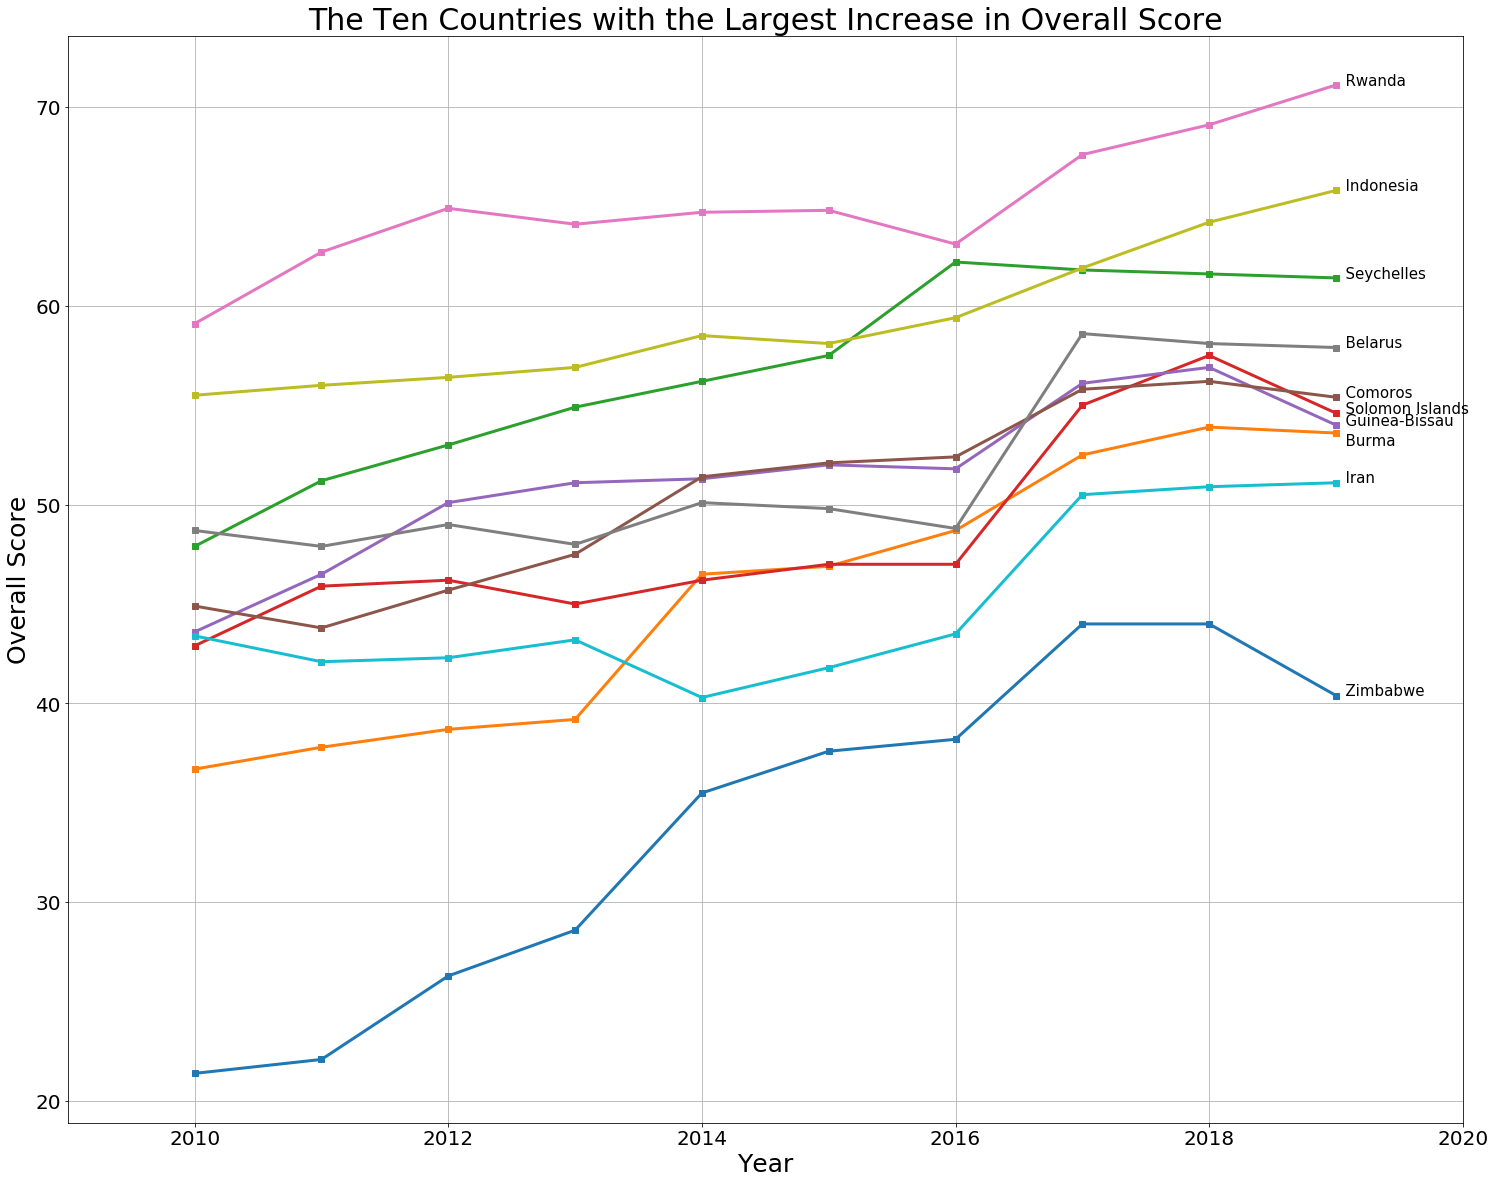

In [34]:
# Plot line chart for countries with most change in overall score
plt.figure(figsize=(25,20))
plt.plot(zimbabwe_df["index_year"], zimbabwe_df["overall_score"], linewidth=3, marker="s")
plt.plot(burma_df["index_year"], burma_df["overall_score"], linewidth=3, marker="s")
plt.plot(seychelles_df["index_year"], seychelles_df["overall_score"], linewidth=3, marker="s")
plt.plot(solomon_df["index_year"], solomon_df["overall_score"], linewidth=3, marker="s")
plt.plot(guinea_df["index_year"], guinea_df["overall_score"], linewidth=3, marker="s")
plt.plot(comoros_df["index_year"], comoros_df["overall_score"], linewidth=3, marker="s")
plt.plot(rwanda_df["index_year"], rwanda_df["overall_score"], linewidth=3, marker="s")
plt.plot(belarus_df["index_year"], belarus_df["overall_score"], linewidth=3, marker="s")
plt.plot(indonesia_df["index_year"], indonesia_df["overall_score"], linewidth=3, marker="s")
plt.plot(iran_df["index_year"], iran_df["overall_score"], linewidth=3, marker="s")

# Place a black text label at the end of each plotted line rather than use a legend
plt.text(2019, zimbabwe_df.overall_score.tail(1), "  Zimbabwe", horizontalalignment="left", fontsize=15, color="k")
plt.text(2019, burma_df.overall_score.tail(1), "  Burma", horizontalalignment="left", va="top", fontsize=15, color="k")
plt.text(2019, seychelles_df.overall_score.tail(1), "  Seychelles", horizontalalignment="left", fontsize=15, color="k")
plt.text(2019, solomon_df.overall_score.tail(1), "  Solomon Islands", horizontalalignment="left", fontsize=15, color="k")
plt.text(2019, guinea_df.overall_score.tail(1), "  Guinea-Bissau", horizontalalignment="left",  fontsize=15, color="k")
plt.text(2019, comoros_df.overall_score.tail(1), "  Comoros", horizontalalignment="left", fontsize=15, color="k")
plt.text(2019, rwanda_df.overall_score.tail(1), "  Rwanda", horizontalalignment="left", fontsize=15, color="k")
plt.text(2019, belarus_df.overall_score.tail(1), "  Belarus", horizontalalignment="left", fontsize=15, color="k")
plt.text(2019, indonesia_df.overall_score.tail(1), "  Indonesia", horizontalalignment="left", fontsize=15, color="k")
plt.text(2019, iran_df.overall_score.tail(1), "  Iran", horizontalalignment="left", fontsize=15, color="k")
#plt.legend()

# Title and label
plt.title("The Ten Countries with the Largest Increase in Overall Score", fontsize=30)
plt.ylabel("Overall Score", fontsize=25)
plt.xlabel("Year", fontsize=25)
plt.xlim(2009,2020)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid()

#Save the figure
plt.savefig("Images/FIG_07_top10_countries.png")

In [35]:
# Combine overall score with region to analyze region
region_merge = pd.merge(merged_df, region_df,on='name', how='left')
region_merge["score_change"] = (region_merge["score_2019"]/region_merge["score_2010"]) * 100
region_merge.head()

,name,year_2010,score_2010,score_2019,year_2019,region,score_change
0,Albania,2010,66.0,66.5,2019,Europe,100.757576
1,Algeria,2010,56.9,46.2,2019,Middle East and North Africa,81.195079
2,Angola,2010,48.4,50.6,2019,Sub-Saharan Africa,104.545455
3,Argentina,2010,51.2,52.2,2019,Americas,101.953125
4,Armenia,2010,69.2,67.7,2019,Europe,97.832370


In [36]:
#highest_2019 = region_merge.nlargest(15, "score_2019", keep='first')
#highest_2019.reset_index(drop=True)

In [37]:
# Find the top 10 change in overall score for 2019-2010
#top_10_reg = region_merge.nlargest(10, "score_change", keep='first')
#top_10_reg

In [38]:
#Get the coutries with the highest overall scores for 2019
#print(df_2019)
country_rank_2019 = df_2019.nlargest(5, "overall score")
country_rank_2019 = country_rank_2019.rename(columns={"overall score": "overall_score"})
print(country_rank_2019)

            name  overall_score  year
72     Hong Kong           90.2  2019
149    Singapore           89.4  2019
122  New Zealand           84.4  2019
160  Switzerland           81.9  2019
6      Australia           80.9  2019


In [39]:
#Get the countries with the highest overall scores for 2010
country_rank_2010 = df_2010.nlargest(5, "overall score")
country_rank_2010 = country_rank_2010.rename(columns = {"overall score": "overall_score"})
print(country_rank_2010)

            name  index year  overall_score
68     Hong Kong        2010           89.7
144    Singapore        2010           86.1
6      Australia        2010           82.6
115  New Zealand        2010           82.1
75       Ireland        2010           81.3


In [40]:
# Put dataframe values into lists
country_2019 = country_rank_2019.name.values.tolist()
overallscore_2019 = country_rank_2019.overall_score.values.tolist()
country_2010 = country_rank_2010.name.values.tolist()
overallscore_2010 = country_rank_2010.overall_score.values.tolist()
#print(score)

Text(0.5, 1.0, '2019 Top 5 Countries with the Highest Economic Index')

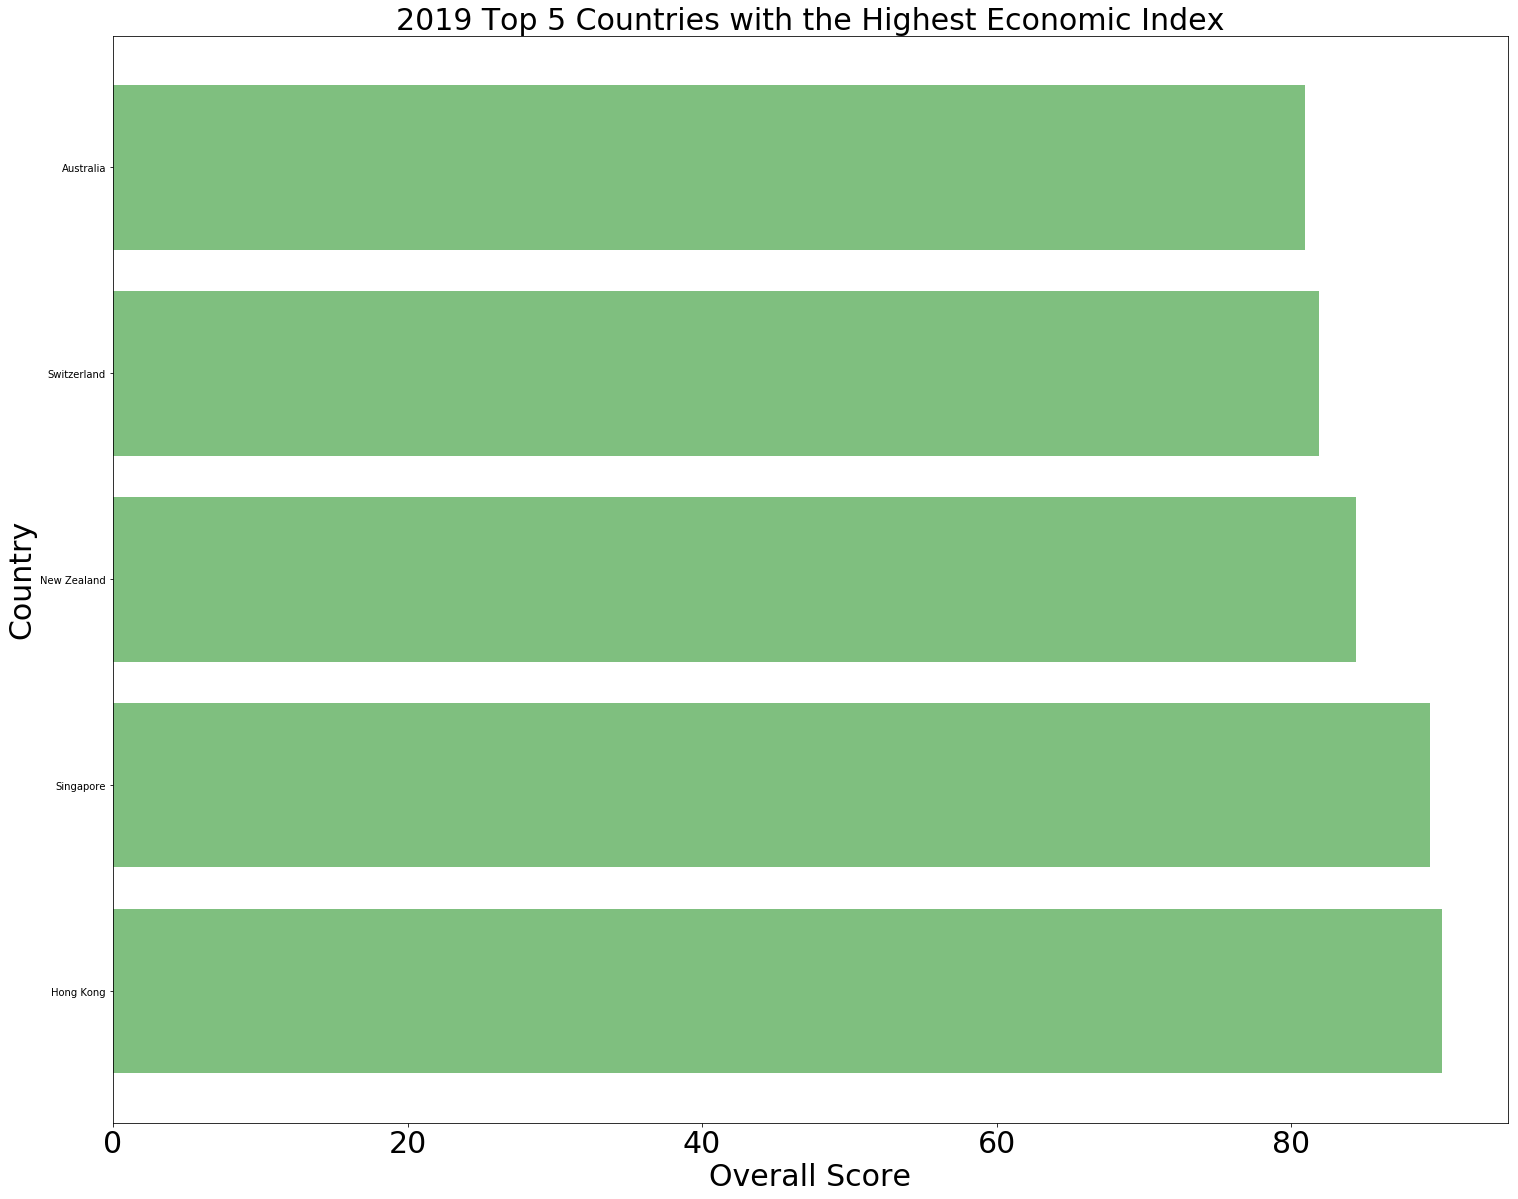

In [41]:
#Plot bar chart of countries with highest overall score
plt.figure(figsize=(25,20))
plt.barh(country_2019, overallscore_2019,align="center", alpha=0.5, color='g')

#plt.bar(country_2010, overallscore_2010)
plt.ylabel("Country", fontsize=30)
plt.xlabel("Overall Score", fontsize=30)
plt.xticks(fontsize = 30)
plt.title("2019 Top 5 Countries with the Highest Economic Index", fontsize=30)

In [42]:
# Get values for highest, lowest and US 
hk_df = decade_df[decade_df["name"] == "Hong Kong"]
nkorea_df = decade_df[decade_df["name"] == "North Korea"]
us_df = decade_df[decade_df["name"] == "United States"]

us_compare_df = pd.merge(hk_df, nkorea_df, how= "outer")
us_compare_df = pd.merge(us_compare_df, us_df, how= "outer")

#Rename the columns so no spaces
us_compare_df = us_compare_df.rename(columns={"index year": "index_year", "overall score": "overall_score"})
us_compare_df.head()

,index_year,name,overall_score
0,2010.0,Hong Kong,89.7
1,2011.0,Hong Kong,89.7
2,2012.0,Hong Kong,89.9
3,2013.0,Hong Kong,89.3
4,2014.0,Hong Kong,90.1


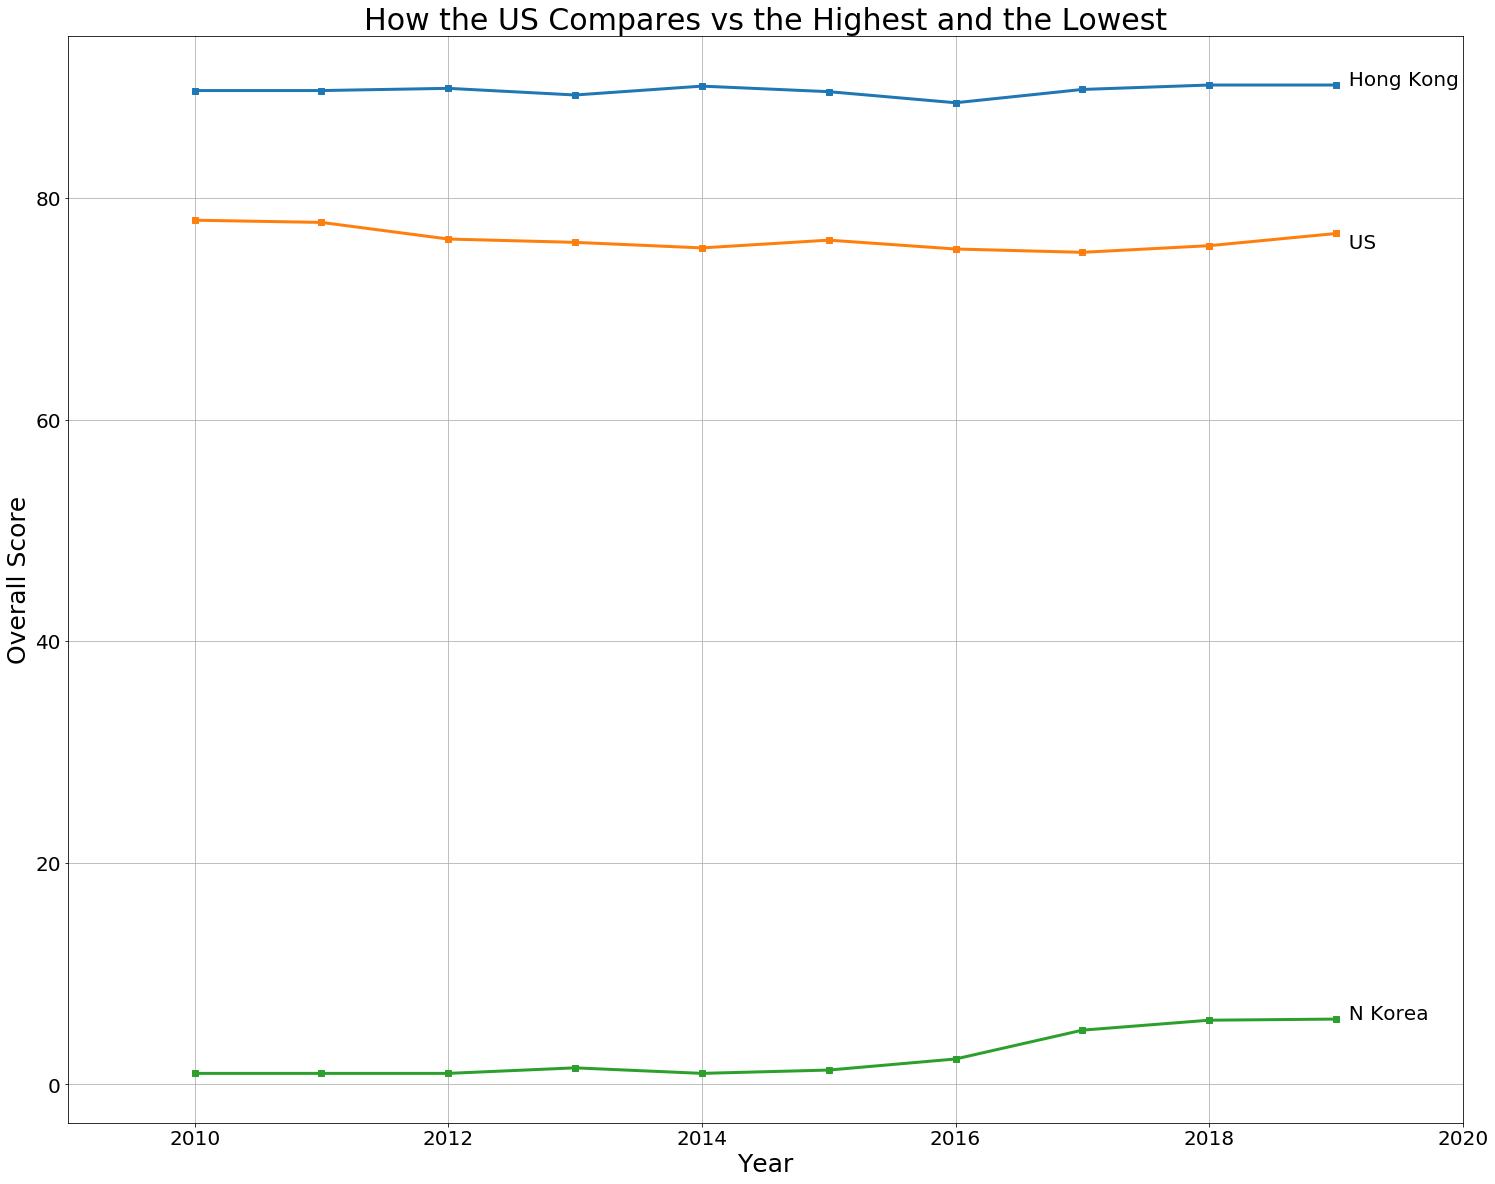

In [43]:
# Graph the highest, lowest and US overall score
plt.figure(figsize=(25,20))
plt.plot(hk_df["index_year"], hk_df["overall_score"], linewidth=3, marker="s")
plt.plot(us_df["index_year"], us_df["overall_score"], linewidth=3, marker="s")
plt.plot(nkorea_df["index_year"], nkorea_df["overall_score"], linewidth=3, marker="s")

# Place a black text label at the end of each plotted line rather than use a legend
plt.text(2019, hk_df.overall_score.tail(1), "  Hong Kong", horizontalalignment="left", fontsize=20, color="k")
plt.text(2019, us_df.overall_score.tail(1), "  US", horizontalalignment="left", va="top", fontsize=20, color="k")
plt.text(2019, nkorea_df.overall_score.tail(1), "  N Korea", horizontalalignment="left", fontsize=20, color="k")

# Title and label
plt.title("How the US Compares vs the Highest and the Lowest", fontsize=30)
plt.ylabel("Overall Score", fontsize=25)
plt.xlabel("Year", fontsize=25)
plt.xlim(2009,2020)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid()
#Save the figure
plt.savefig("Images/FIG_08_USvsHighLow.png")

In [44]:
index_year_df.head()

,name,index_year,overall_score,property rights,government integrity,judicial effectiveness,tax burden,government spending,fiscal health,business freedom,labor freedom,monetary freedom,trade freedom,investment freedom,financial freedom,region
9,Afghanistan,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia-Pacific
21,Albania,2010.0,66.0,35.0,34.0,NaN,92.6,74.2,NaN,68.0,52.1,78.7,85.8,70.0,70.0,Europe
33,Algeria,2010.0,56.9,30.0,32.0,NaN,83.5,73.4,NaN,71.2,56.4,77.2,70.7,45.0,30.0,Middle East and North Africa
45,Angola,2010.0,48.4,20.0,19.0,NaN,85.1,62.8,NaN,43.4,45.2,62.6,70.4,35.0,40.0,Sub-Saharan Africa
57,Argentina,2010.0,51.2,20.0,29.0,NaN,69.5,75.6,NaN,62.1,50.1,61.2,69.5,45.0,30.0,Americas


In [45]:
#Reset index
tired_df = index_year_df.reset_index(drop=True)
tired_df.head()
tired_df.count()

# Separate each of the top 10 countries into their own DataFrame
#new_info_df = index_year_df[["index_year", "name", "overall_score"]]
#index_2019_df = index_year_df[new_info_df["index_year"] == "2019.0"]
#index_2019_df

name                      1880
index_year                1853
overall_score             1788
property rights           1815
government integrity      1831
judicial effectiveness     554
tax burden                1804
government spending       1814
fiscal health              552
business freedom          1827
labor freedom             1825
monetary freedom          1818
trade freedom             1807
investment freedom        1819
financial freedom         1802
region                    1610
dtype: int64

In [46]:
# Bin the countries by overall score into freedom index groups

pre_bin_df = tired_df[["name", "index_year", "overall_score"]]
pre_bin_df = pre_bin_df.dropna(how="any")
pre_bin_df.head()

,name,index_year,overall_score
1,Albania,2010.0,66.0
2,Algeria,2010.0,56.9
3,Angola,2010.0,48.4
4,Argentina,2010.0,51.2
5,Armenia,2010.0,69.2


In [47]:
pre_bin_df2 =pre_bin_df[pre_bin_df.index_year==2019.0]
pre_bin_df2=pre_bin_df2.reset_index(drop=True)
pre_bin_df2.head()

,name,index_year,overall_score
0,Afghanistan,2019.0,51.5
1,Albania,2019.0,66.5
2,Algeria,2019.0,46.2
3,Angola,2019.0,50.6
4,Argentina,2019.0,52.2


In [48]:
# Create bins and labels

score_bins = [0, 49.9, 59.9, 69.9, 79.9, 100]
#score_bins = [100, 80, 70, 60, 50, 0]
#score_labels = ["Free: >80", "Mostly Free: 70-79.9", "Moderately Free: 60-69.9", 
#               "Mostly UnFree: 50-59.9", "Repressed: <50"]
score_labels = ["Repressed: <50", "Mostly UnFree: 50-59.9", "Moderately Free: 60-69.9", 
               "Mostly Free: 70-79.9", "Free: >80"]
pd.cut(pre_bin_df2["overall_score"], score_bins, labels=score_labels)
#pre_bin_df2["efi_rank"] = pd.cut(pre_bin_df2["overall_score"], score_bins, labels=score_labels)
pre_bin_df2["rank"] = pd.cut(pre_bin_df2["overall_score"], score_bins, labels=score_labels)
pre_bin_df2.head()

,name,index_year,overall_score,rank
0,Afghanistan,2019.0,51.5,Mostly UnFree: 50-59.9
1,Albania,2019.0,66.5,Moderately Free: 60-69.9
2,Algeria,2019.0,46.2,Repressed: <50
3,Angola,2019.0,50.6,Mostly UnFree: 50-59.9
4,Argentina,2019.0,52.2,Mostly UnFree: 50-59.9


In [49]:
# Get average of bin groups
bin_group = pre_bin_df2.groupby("rank")
bin_group[["name", "overall_score"]].mean()

,overall_score
rank,
Repressed: <50,42.340909
Mostly UnFree: 50-59.9,55.056250
Moderately Free: 60-69.9,64.683051
Mostly Free: 70-79.9,74.468966
Free: >80,84.550000


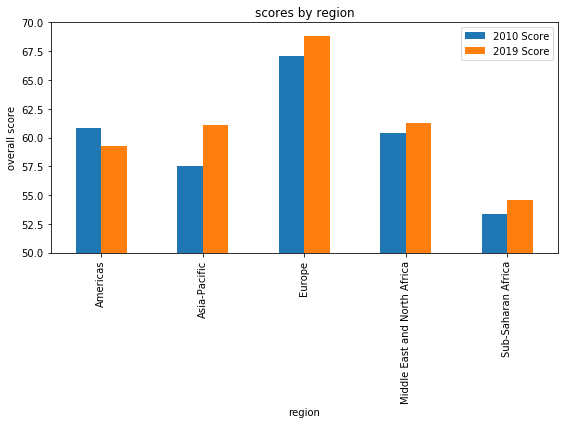

In [50]:
#pull col's from merged df to make new table
region_table = primary_df[["name", "index year", "overall score", "region"]]
# region_table.head()
#create df's to compare begin & end of 10 year timeframe (2010-present)
year_2010 = region_table.loc[region_table["index year"] == 2010]
year_2019 = region_table.loc[region_table["index year"] == 2019]
#sort by regions and find average for 2 comparison years
region_group_2010 = year_2010.groupby(["region"])
region_summary_2010 = region_group_2010.mean()
region_group_2019 = year_2019.groupby(["region"])
region_summary_2019 = region_group_2019.mean()
# region_summary_2019
#merge 2 new df's together for comparison
merge_years = pd.merge(region_summary_2010, region_summary_2019, how='outer',
                      on='region')
merge_summary = merge_years[["overall score_x", "overall score_y"]]
#rename col's for easier understanding
merge_summary = merge_summary.rename(columns={"overall score_x": "2010 Score",
                                         "overall score_y": "2019 Score"})
merge_summary.head()
#create bar graph and set title/labels & y limit to show differences
region_bar = merge_summary.plot(kind="bar", title="scores by region", figsize=(8,6))
region_bar.set_xlabel("region")
region_bar.set_ylabel("overall score")
plt.ylim(50, 70)
plt.tight_layout() # helps labels display in saved image
plt.savefig("Images/FIG_09_region_scores.png")
plt.show()

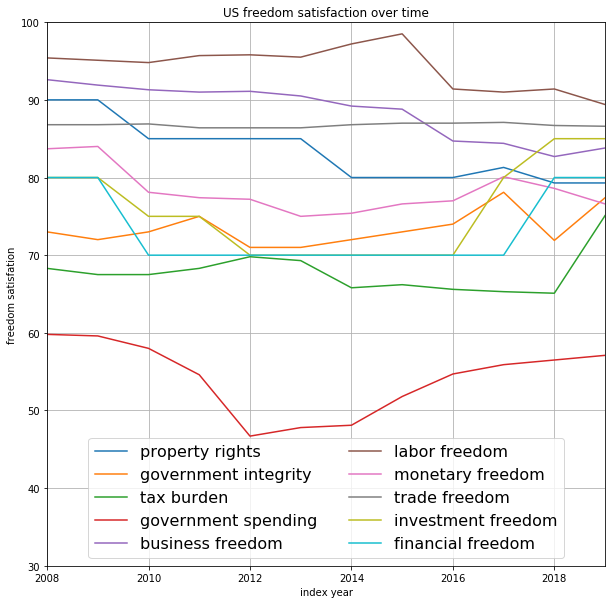

In [51]:
us_df = primary_df.loc[primary_df["name"] == "United States"]
us_df.head()
us_drop = us_df[["index year", "property rights", "government integrity", "tax burden",
                "government spending", "business freedom", "labor freedom", "monetary freedom",
                "trade freedom", "investment freedom", "financial freedom"]]
new_labels = us_drop.set_index("index year")
# new_labels.head()
us_chart = new_labels.plot(kind='line', title='US freedom satisfaction over time', grid=True, figsize=(10,10))
us_chart.set_xlabel("index year")
us_chart.set_ylabel("freedom satisfation")
plt.ylim(30,100)
plt.legend(ncol=2, loc="lower center", prop={'size': 16})
plt.savefig("Images/FIG_10_usFreedoms.png")
plt.show()